In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Parameters

In [2]:
N=60000

digits = 3
input_digits = digits*2 + 1
output_digits = digits + 1

n_epochs=200
batch_size = 100

# Data

In [3]:
def n(digits=digits):
    number = ''
    
    for i in range(np.random.randint(1, digits+1)):
        number += np.random.choice(list('0123456789'))
    
    return int(number)

In [4]:
def padding(chars, maxlen):
    return chars + ' '*(maxlen - len(chars))

In [5]:
added = set()
questions = []
answers = []

while len(questions) < N:
    
    a, b = n(), n()
    
    pair = tuple(sorted((a, b)))
    if pair in added:
        continue
        
    question = '{}+{}'.format(a, b)
    question = padding(question, input_digits)
    
    answer = str(a+b)
    answer = padding(answer, output_digits)
    
    added.add(pair)
    questions.append(question)
    answers.append(answer)

# One-hot encoding

In [6]:
chars = '0123456789+ '
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [7]:
X = np.zeros((len(questions), input_digits, len(chars)), dtype=np.integer)
Y = np.zeros((len(questions), output_digits, len(chars)), dtype=np.integer)

for i in range(N):
    for t, char in enumerate(questions[i]):
        X[i, t, char_indices[char]] = 1
    
    for t, char in enumerate(answers[i]):
        Y[i, t, char_indices[char]] = 1

# Train / Validation / Test Data

In [8]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, train_size=0.7)

/Users/rackhun/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Model

In [9]:
def inference(x, y, n_batch, is_training, input_digits=None, output_digits=None, n_hidden=None, n_out=None):
    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype = tf.float32)
        return tf.Variable(initial)
    
    
    # Encoder
    encoder = tf.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0)
    state = encoder.zero_state(n_batch, tf.float32)
    encoder_outputs = []
    encoder_states = []
    
    with tf.variable_scope('Encoder'):
        for t in range(input_digits):
            if t>0:
                tf.get_variable_scope().reuse_variables()
                
            (output, state) = encoder(x[:, t, :], state)
            
            encoder_outputs.append(output)
            encoder_states.append(state)
    
    # Decoder
    decoder = tf.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0)
    state = encoder_states[-1]
    decoder_outputs = [encoder_outputs[-1]]
    
    #### Final layer variables
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    outputs = []
    ####
    
    with tf.variable_scope('Decoder'):
        for t in range(1, output_digits):
            if t>1:
                tf.get_variable_scope().reuse_variables()
            
            if is_training is True:
                (output, state) = decoder(y[:, t-1, :], state)
            else:
                linear = tf.matmul(decoder_outputs[-1], V) + c
                out = tf.nn.softmax(linear)
                outputs.append(out)
                #out = tf.one_hot(tf.argmax(out, -1), depth=output_digits)  ## ??
                out = tf.one_hot(tf.argmax(out, -1), depth=n_out)
                (output, state) = decoder(out, state)
            
            decoder_outputs.append(output)
            

    if is_training is True:
        output = tf.reshape( tf.concat(decoder_outputs, axis=1), [-1, output_digits, n_hidden] )
        linear = tf.einsum('ijk, kl -> ijl', output, V) + c
        return tf.nn.softmax(linear)
    
    else:
        linear = tf.matmul(decoder_outputs[-1], V) + c
        out = tf.nn.softmax(linear)
        outputs.append(out)
        
        output = tf.reshape(tf.concat(outputs, axis=1),
                                        [-1, output_digits, n_out])
        return output

def loss (y, t):
    cross_entropy = tf.reduce_mean( -tf.reduce_sum( t*tf.log(tf.clip_by_value(y, 1e-10, 1.0)), reduction_indices=[1]))
    return cross_entropy

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

def accuracy(y, t):
    correct_prediction = tf.equal( tf.argmax(y, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean( tf.cast( correct_prediction, tf.float32 ))
    return accuracy


In [10]:
n_in = len(chars)
n_hidden = 128
n_out = len(chars)

x = tf.placeholder(tf.float32, shape=[None, input_digits, n_in], name='x')
t = tf.placeholder(tf.float32, shape=[None, output_digits, n_out], name='t')
n_batch = tf.placeholder(tf.int32, [], name='batch_size')
is_training = tf.placeholder(tf.bool)

y = inference(x, t, n_batch, 
                      is_training = is_training,
                      input_digits = input_digits,
                      output_digits = output_digits,
                      n_hidden = n_hidden,
                      n_out = n_out)

loss = loss(y, t)
train_step = training(loss)
acc = accuracy(y, t)

# Training

In [11]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batchs = X_train.shape[0] // batch_size
n_validation = X_validation.shape[0]
history = { 'val_loss': [], 'val_acc': [] }

for epoch in range(n_epochs):
    X_, Y_, = shuffle(X_train, Y_train)
    
    for i in range(n_batchs):
        start = i * batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={x: X_[start:end], 
                                                        t: Y_[start:end], 
                                                        n_batch: batch_size, 
                                                        is_training: True})
        
    val_loss, val_acc = sess.run([loss, acc], feed_dict={x: X_validation, 
                                                                                 t: Y_validation, 
                                                                                 n_batch: n_validation, 
                                                                                 is_training: False})
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if epoch % 20 == 0:
        print(epoch,'th epoch')
        for i in range(2):
            index = np.random.randint(0, n_validation)
            question = X_validation[np.array([index])]
            answer = Y_validation[np.array([index])]
            prediction = sess.run(y, feed_dict={x: question, 
                                                               #t: answer,
                                                               n_batch: 1,
                                                               is_training: False })
        
            question = question.argmax(axis=-1)
            answer = answer.argmax(axis=-1)
            prediction = np.argmax(prediction, -1)
        
            q = ' '.join(indices_char[i] for i in question[0])
            a = ' '.join(indices_char[i] for i in answer[0])
            p = ' '.join(indices_char[i] for i in prediction[0])
        
            print('-'*10)
            print('Q: ', q)
            print('A: ', a)
            print('P: ', p)
            print('T/F: ', end=' ')
        
            if a == p:
                print('T')
            else:
                print('F')

0 th epoch
----------
Q:  6 + 7 3 3    
A:  7 3 9  
P:  5 4    
T/F:  F
----------
Q:  2 6 0 + 4 7  
A:  3 0 7  
P:  5 0 4  
T/F:  F
20 th epoch
----------
Q:  6 0 + 8 2 6  
A:  8 8 6  
P:  8 8 5  
T/F:  F
----------
Q:  3 6 1 + 4 4  
A:  4 0 5  
P:  3 9 5  
T/F:  F
40 th epoch
----------
Q:  3 8 9 + 5    
A:  3 9 4  
P:  3 9 4  
T/F:  T
----------
Q:  5 6 3 + 5 3  
A:  6 1 6  
P:  6 1 6  
T/F:  T
60 th epoch
----------
Q:  9 + 7 5 9    
A:  7 6 8  
P:  7 6 8  
T/F:  T
----------
Q:  6 5 2 + 2 1 9
A:  8 7 1  
P:  8 7 1  
T/F:  T
80 th epoch
----------
Q:  3 3 7 + 5 4 0
A:  8 7 7  
P:  8 7 7  
T/F:  T
----------
Q:  2 1 4 + 4    
A:  2 1 8  
P:  2 1 8  
T/F:  T
100 th epoch
----------
Q:  5 1 4 + 7 6 2
A:  1 2 7 6
P:  1 2 7 6
T/F:  T
----------
Q:  9 5 + 9 8    
A:  1 9 3  
P:  1 9 3  
T/F:  T
120 th epoch
----------
Q:  1 1 0 + 1 7 2
A:  2 8 2  
P:  2 8 2  
T/F:  T
----------
Q:  9 4 + 2 4 9  
A:  3 4 3  
P:  3 4 3  
T/F:  T
140 th epoch
----------
Q:  3 9 2 + 6 7 0
A:  1 0 6 2
P:  1 6

# Loss & Accuracy

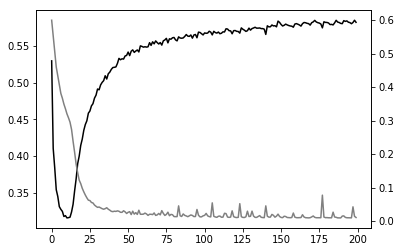

In [13]:
fig = plt.figure()

ax_acc = fig.add_subplot(111)
ax_acc.plot(range(n_epochs), history['val_acc'],
                   label='acc', color='black')

ax_loss = ax_acc.twinx()
ax_loss.plot(range(n_epochs), history['val_loss'],
                    label='loss', color='gray')

plt.xlabel('epoch')
plt.show()